# Steps:
* It should note PILOT creats split folder for each data set and puts the all results there.
* You just need to prvide two data for your interested dataset:
 1. One for annotations such as "cell_type","sampleID" and "status", please make sure to provid these names and the same order for them in your final annot data (check the data with "annot_data_" prefix in Dataset" and see the structures). 
 2. The second data that you need to give to PILOT is the gene expression/morphologica features that it could be also the principal components, without any extra info such name cells or smaples and so on..(check the data with "gene_expression_" prefix in Dataset and see the structures).


In [1]:
from PILOT import *
warnings.filterwarnings('ignore')

## Load data:

In [2]:
#If you already have gene_expression and annotation of data, use the below functions.

path_dataset='Datasets/'  #Path to read datasets
name_dataset='myocardial_infarction' #Name of the data set, please look at the Dataset folder, for each data set we need to split data
path_to_results=set_path_for_results(name_dataset) #set the path for results
annot=load_annot(path_dataset,name='annot_data_'+name_dataset)  #Load annot data.
data=load_expression(path_dataset,name='gene_expression_'+name_dataset) #Load expression data


## Cluster representations by estimating regularized probability distributions of cell types per sample:

In [3]:
Clu_rep = Cluster_Representations(annot,regulizer = 0.1,regularization=True) # Regularization

##  Calcuating  cost matrix between clusters:

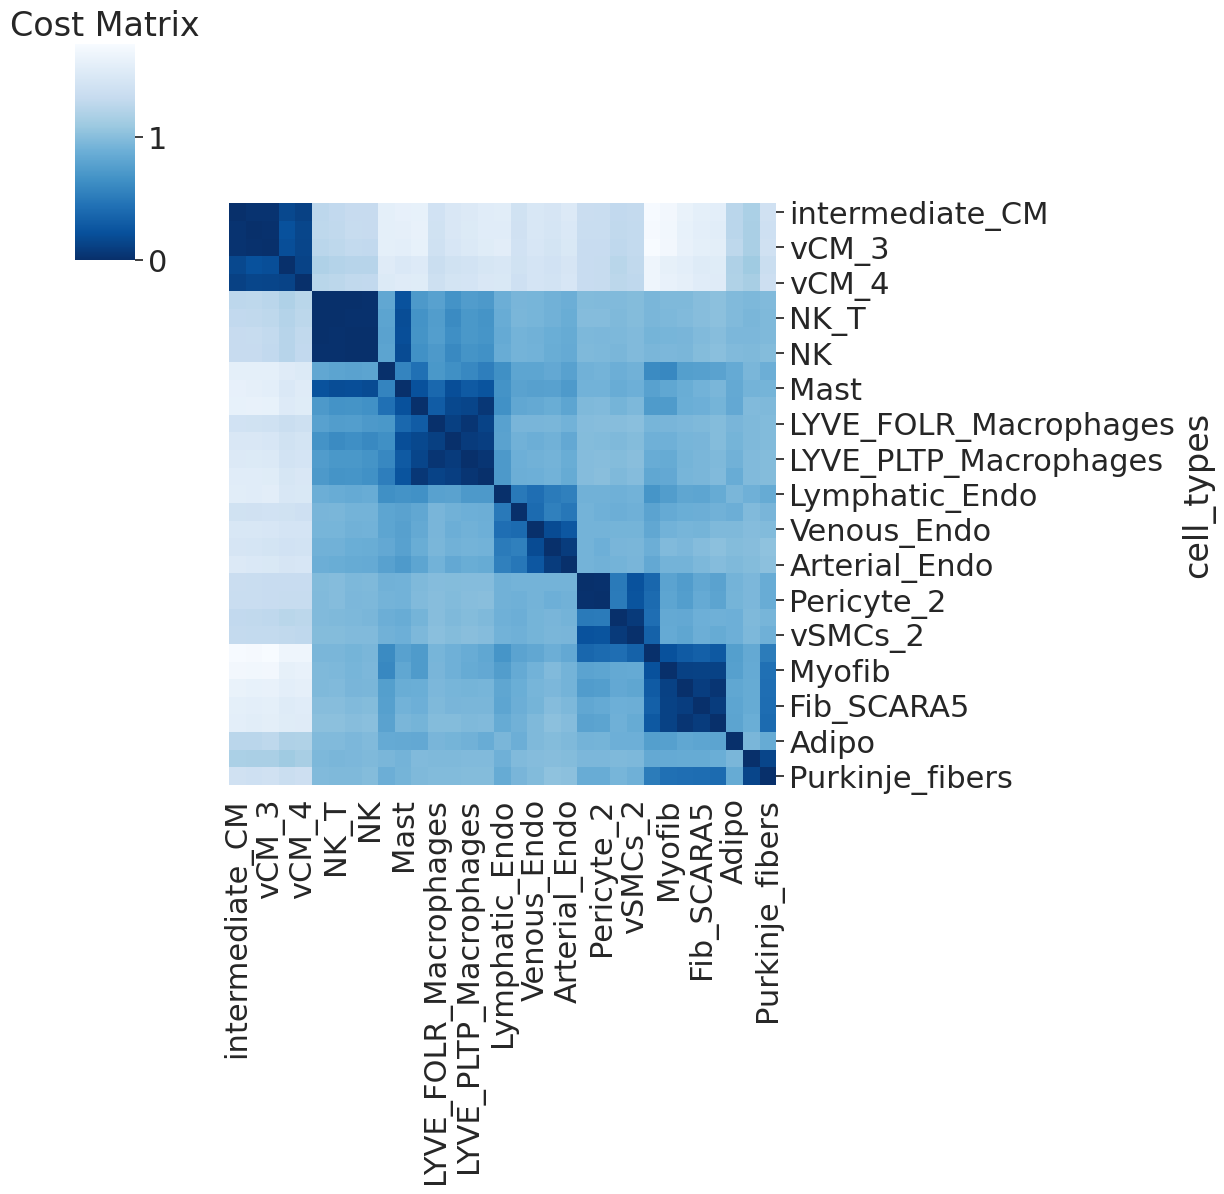

In [4]:
dis= cost_matrix(annot, data,path_to_results,cell_col = 0)

# Estimate the Wasserstein distance:

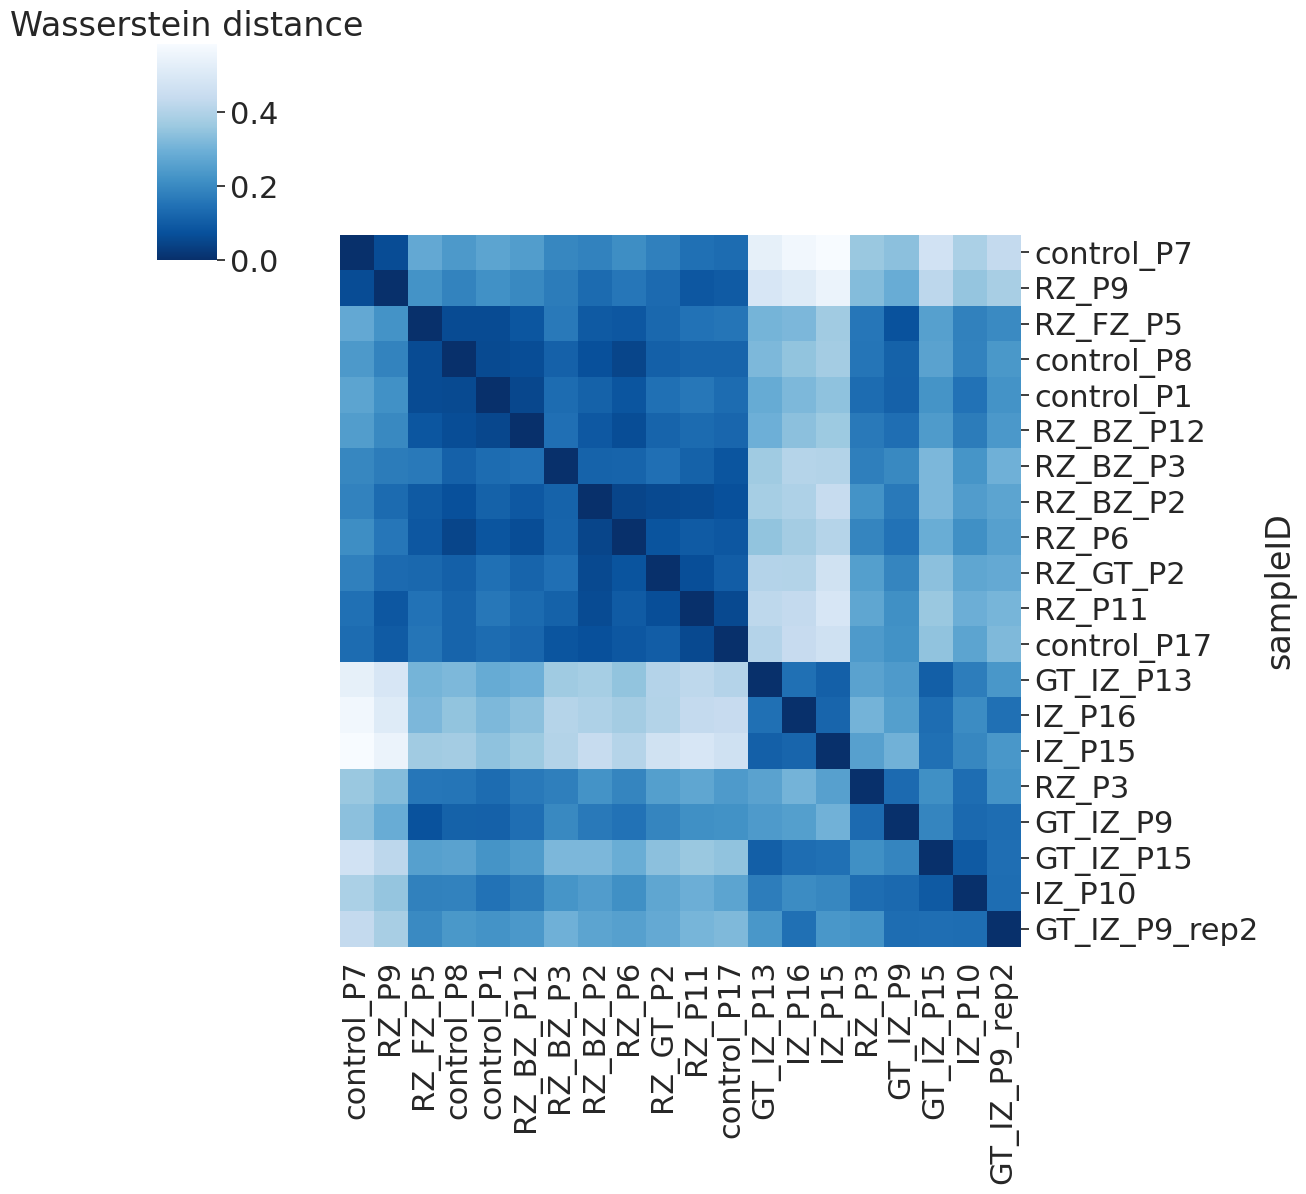

In [5]:
EMD = wasserstein_d(Clu_rep,dis/dis.max(),regularized = 'unreg',path = path_to_results)

## Evaluation:

Cluster labels:  ['control' 'IZ']
ARI:  0.9
Silhouette score:  0.7392560937271608


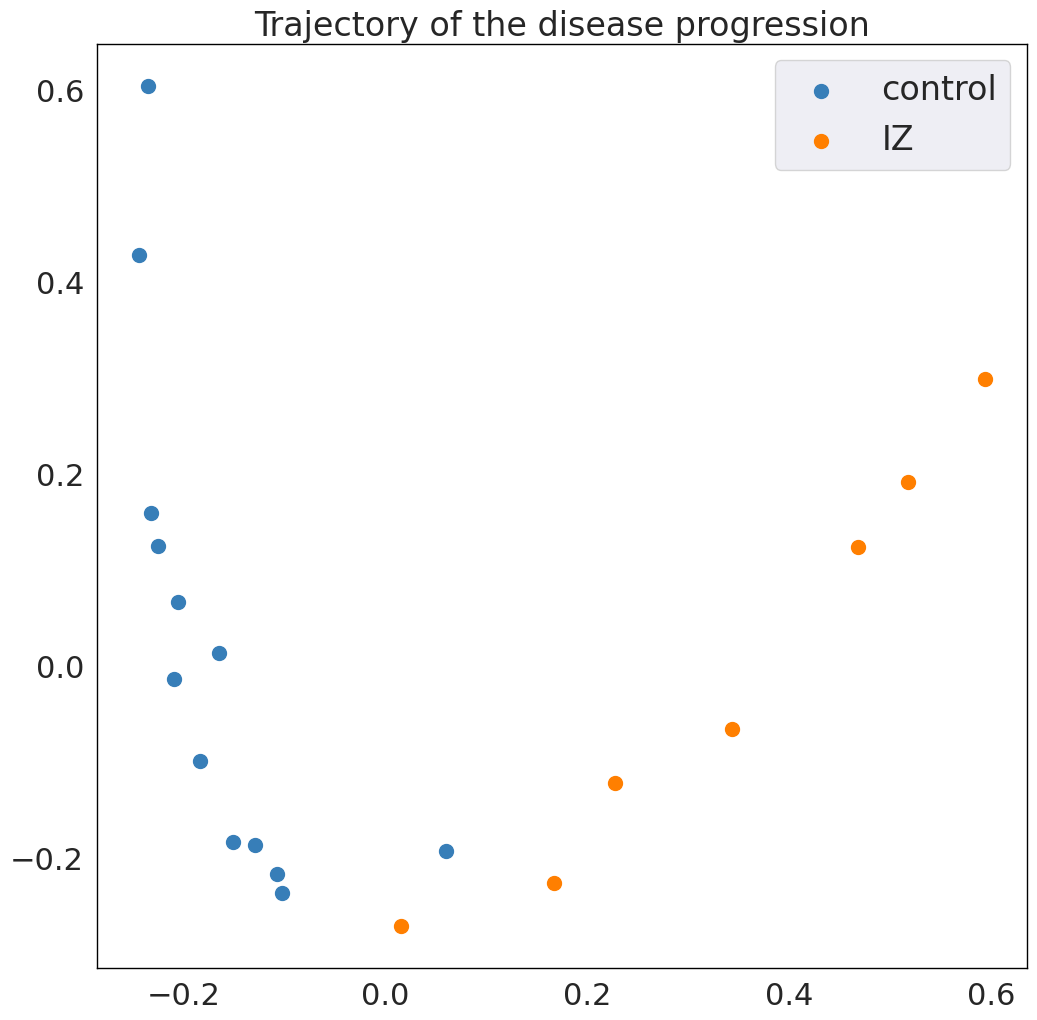

In [6]:
# Computing ARI
predicted_labels, ARI, real_labels = Clustering(EMD/EMD.max(), annot,category ='status', sample_col=1, res = 0.01)
#Computing Sil
Silhouette = Sil_computing(EMD/EMD.max(), real_labels, metric = 'cosine',space = 'diffusion')

#Drawing diffusion map
embedding_diff=trajectory(EMD/EMD.max(), predicted_labels, annot, embed_coord = 'diffusion',path = path_to_results,label_act=False,location_labels='best')


#  Cell-type importance

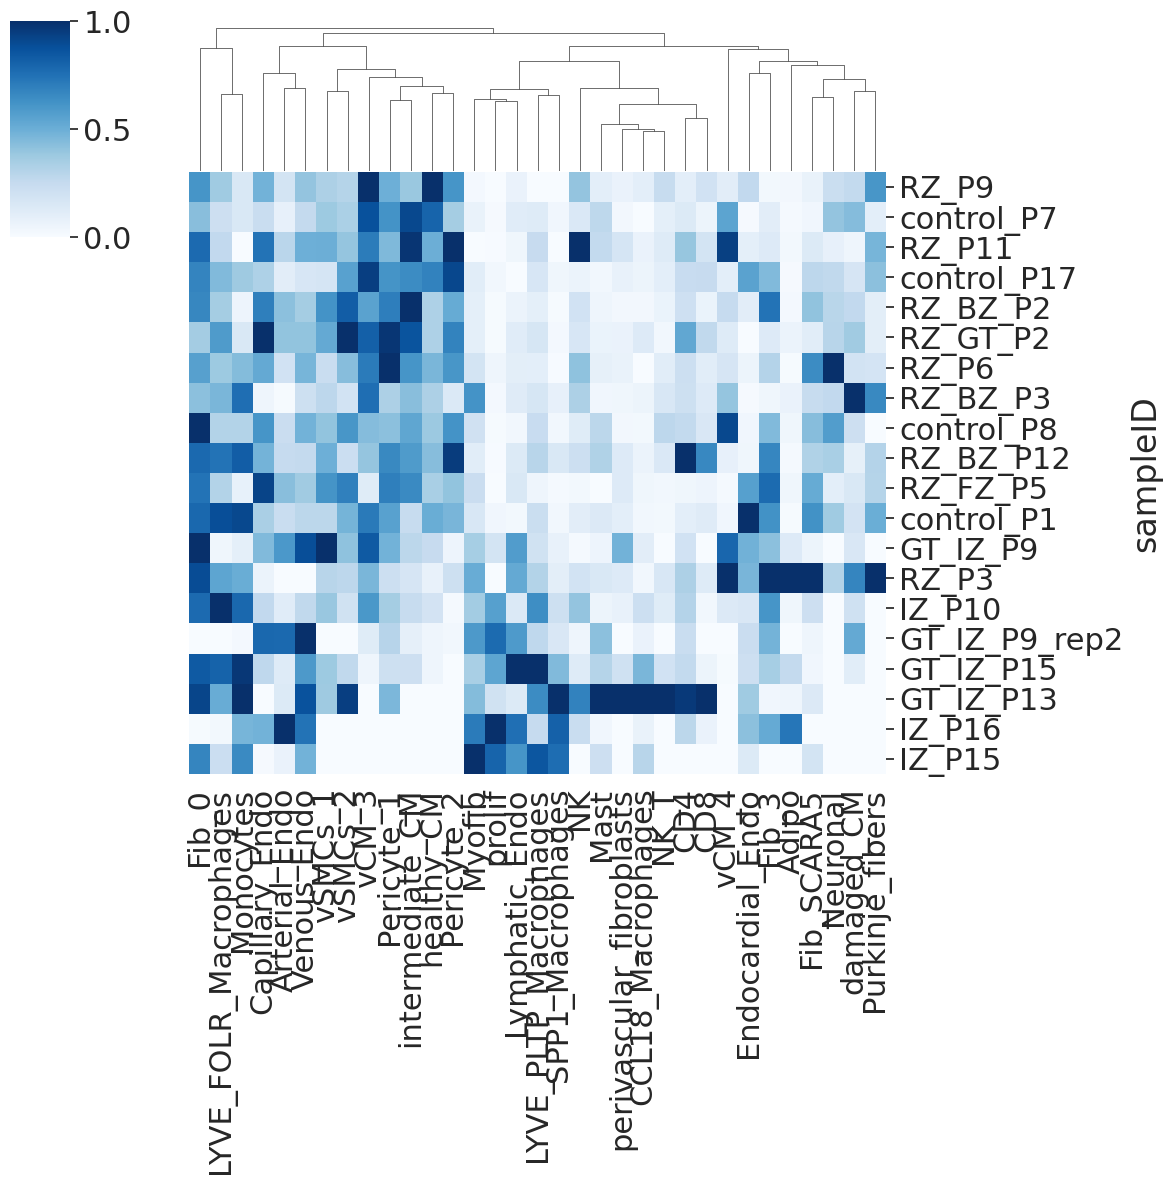

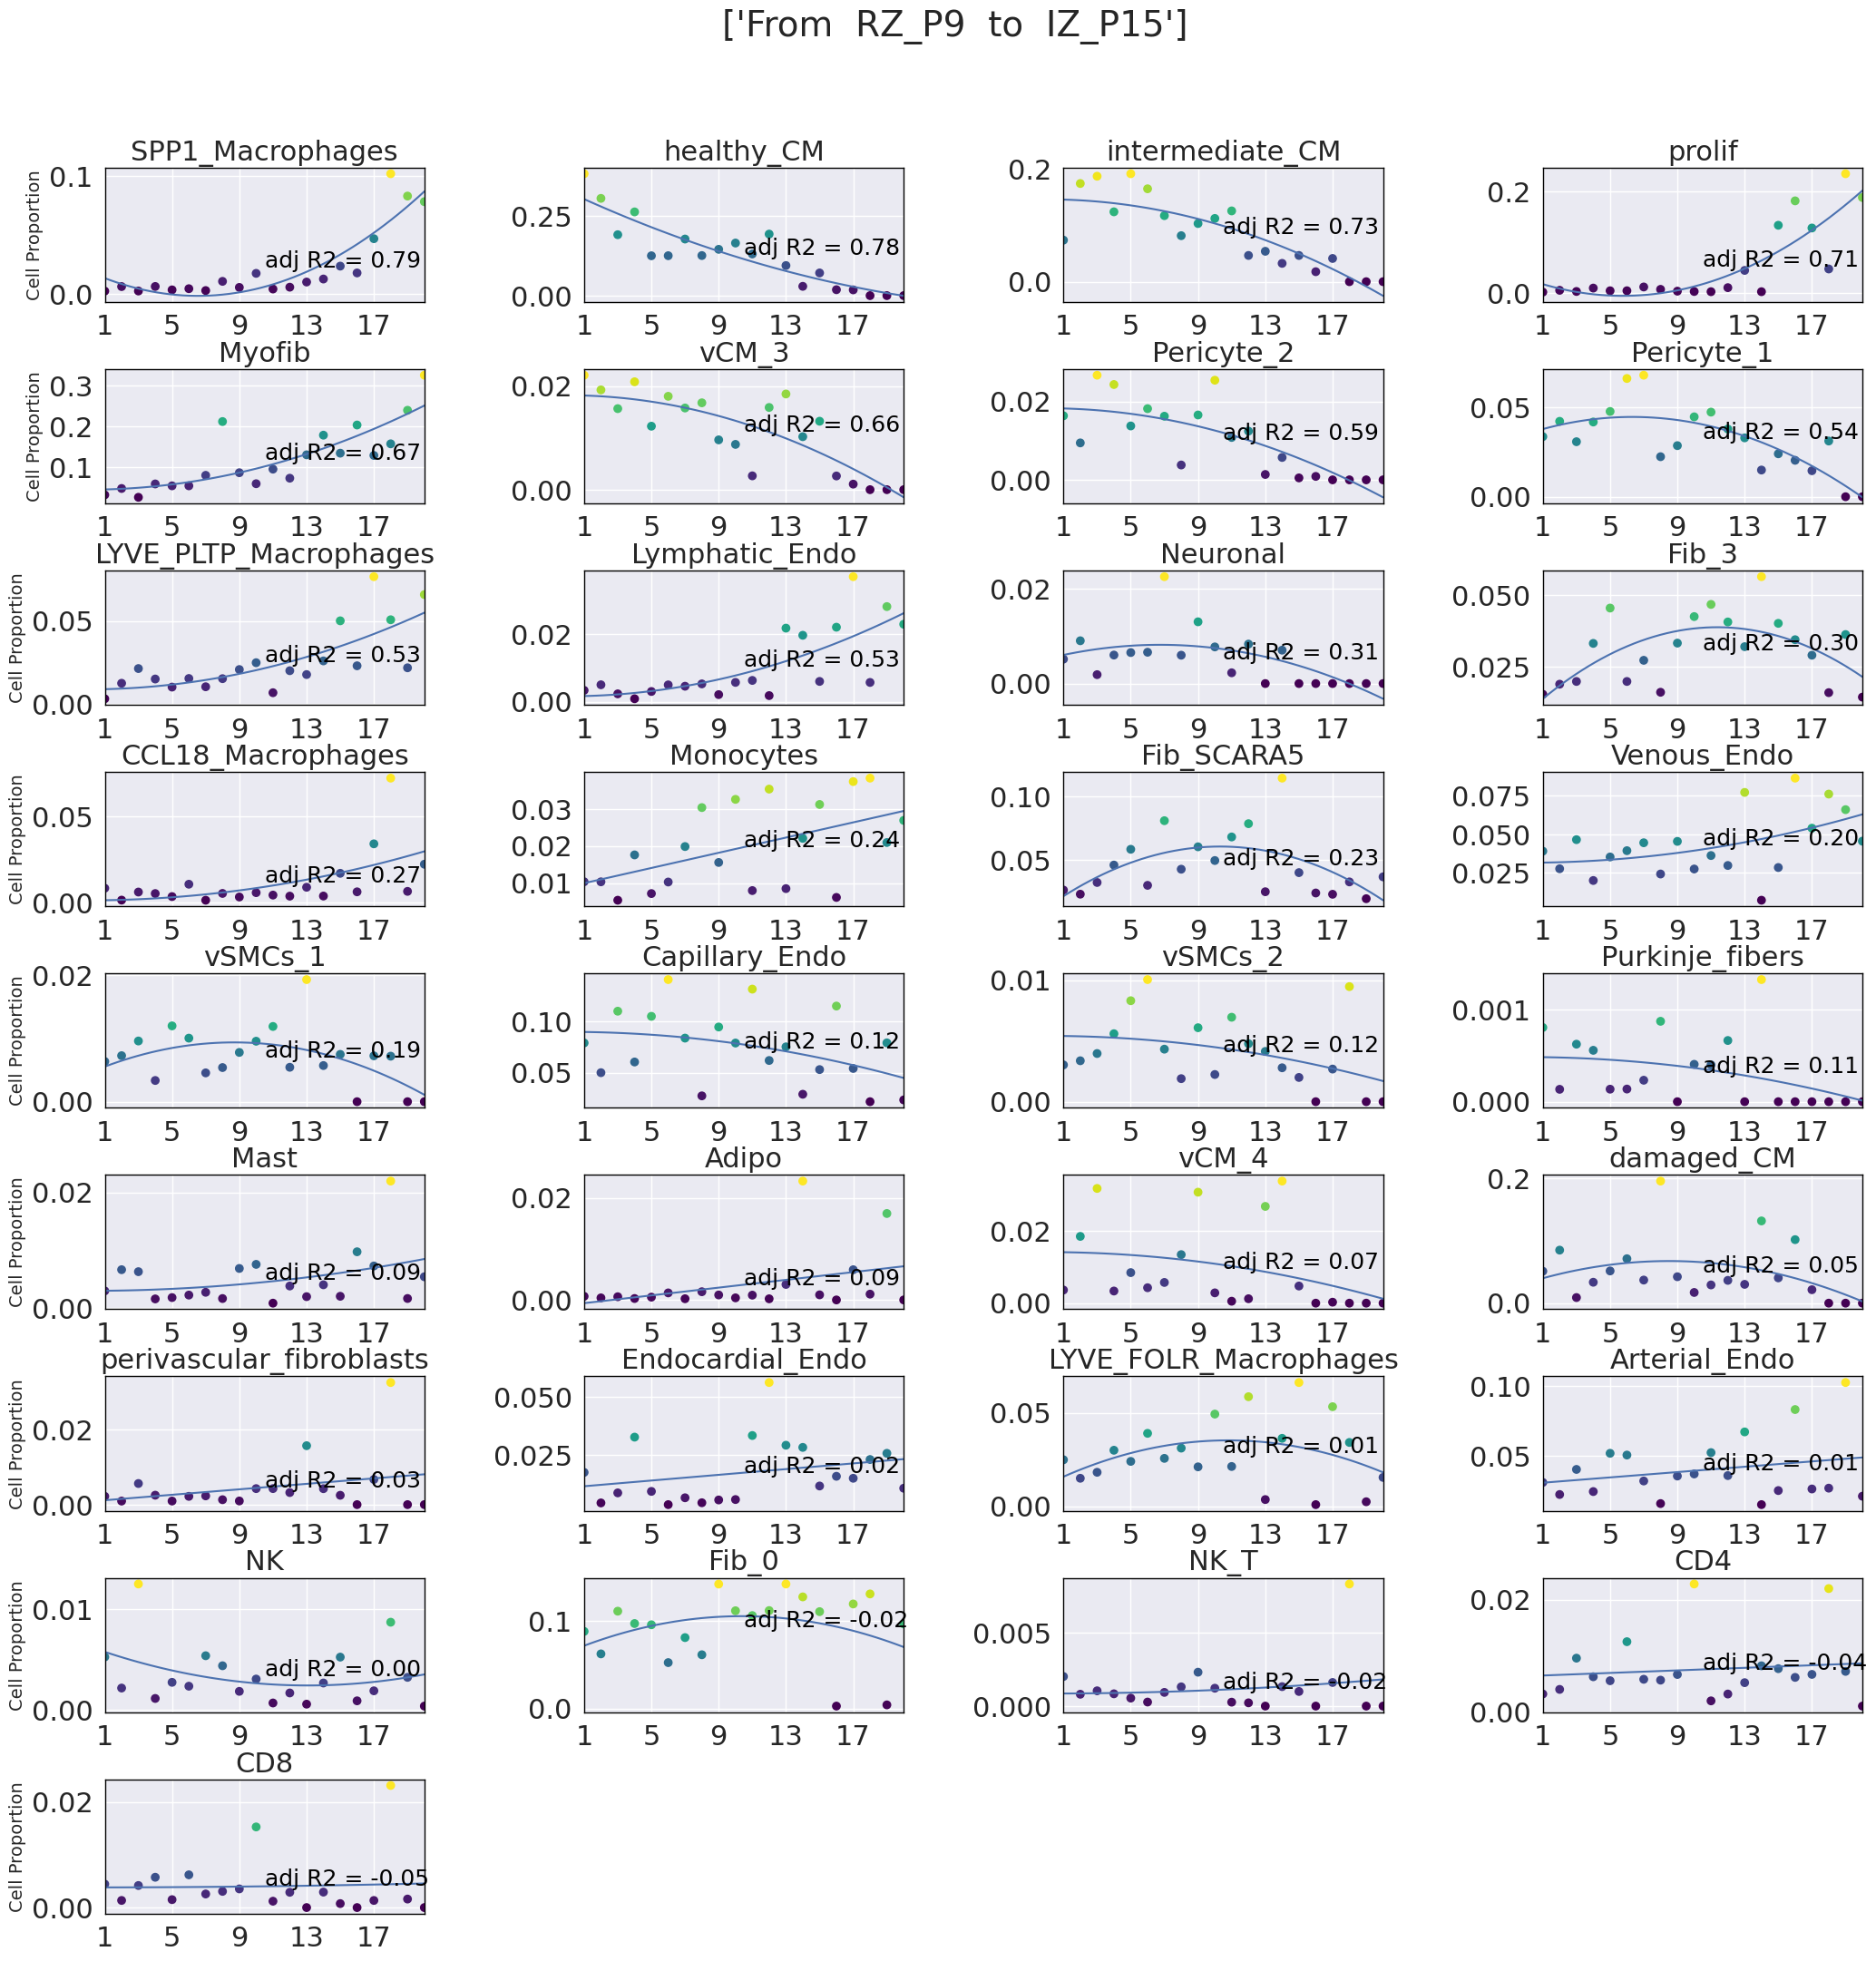

In [7]:
orders,cell_names=Cell_importance(Clu_rep,annot,embedding_diff,real_labels,path=path_to_results,sort_axis='emb_x',width=30,height=35,xlim=4,p_val=1)

## Extract gene expressions from Original object :
This step extracts genes associated with each cell_type (your insterested cells) and map them with the obtained time by PILOT (based on the Trjaectory order of Samples).

* It uses the cell_names list from the previous step.
* You need to use the orinigal obejct (h5ad) to extract genes of each cell-type, we provide the "extract_cells_from_gene_expression" function that you just need to first read the object with load_h5ad and then after determining the sampleID columns and cell-type columns start extracting. Also this function itself reads the orders(time, obtained from the previous step) and map them with the cells. For getting this data download the object from provided link in  "Data and code availability " section in the PILOT paper.





In [8]:
#You need to download this object, for finding the path of this file check the PILOT paper,
adata=load_h5ad('myocardial infarction.h5ad') #load the h5ad file

In [9]:
adata

AnnData object with n_obs × n_vars = 115517 × 29126
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'doublet_score', 'doublet', 'dissociation_s1', 'opt_clust', 'patient', 'batch', 'opt_clust_integrated', 'cell_type', 'ident', 'n_genes', 'cell_subtype', 'cell_subtype_available', 'cell_subtype2', 'sampleID', 'patient_group', 'Status'
    obsm: 'HARMONY', 'PCA', 'UMAP_HARMONY'
    layers: 'logcounts'

In [10]:
#The function "extract_cells_from_gene_expression"  automatically creates a cells folder and put the extracted genes_expression associate with each cell and  obtained time by PILOT(orders).
#Cell_list includes list of your interested cell_types/clusters. you can use the "cell_names" list from the previous step.
# You need to set names of columns that show cell_types/clusters and Samples/Patinets in your object.
extract_cells_from_gene_expression(adata,orders,sample_col='sampleID',col_cell='cell_subtype',cell_list=['healthy_CM','Myofib'],path_results=path_to_results)

# Gene selection:

### Read x and y genes of Chromosomes to filter them:
* Note: We also removed chromosomes genes before gene selection.

In [11]:
x_y_genes=pd.read_csv('Datasets/Chromosome_x_and_y.csv')
x_y_genes=x_y_genes.dropna()
filtered_names=list(x_y_genes['Gene name'])

###  Healthy_CM Celltype

Name of Cell type : healthy_CM
sparsity:0.6932279564364608
For this cell_type, p-value of  3011 genes are statistically significant.
           Expression pattern  count
4    linear up quadratic down   1245
2    linear down quadratic up    557
0                 linear down    523
3                   linear up    314
6              quadratic down    256
7                quadratic up    106
1  linear down quadratic down      8
5      linear up quadratic up      2
data saved successfully


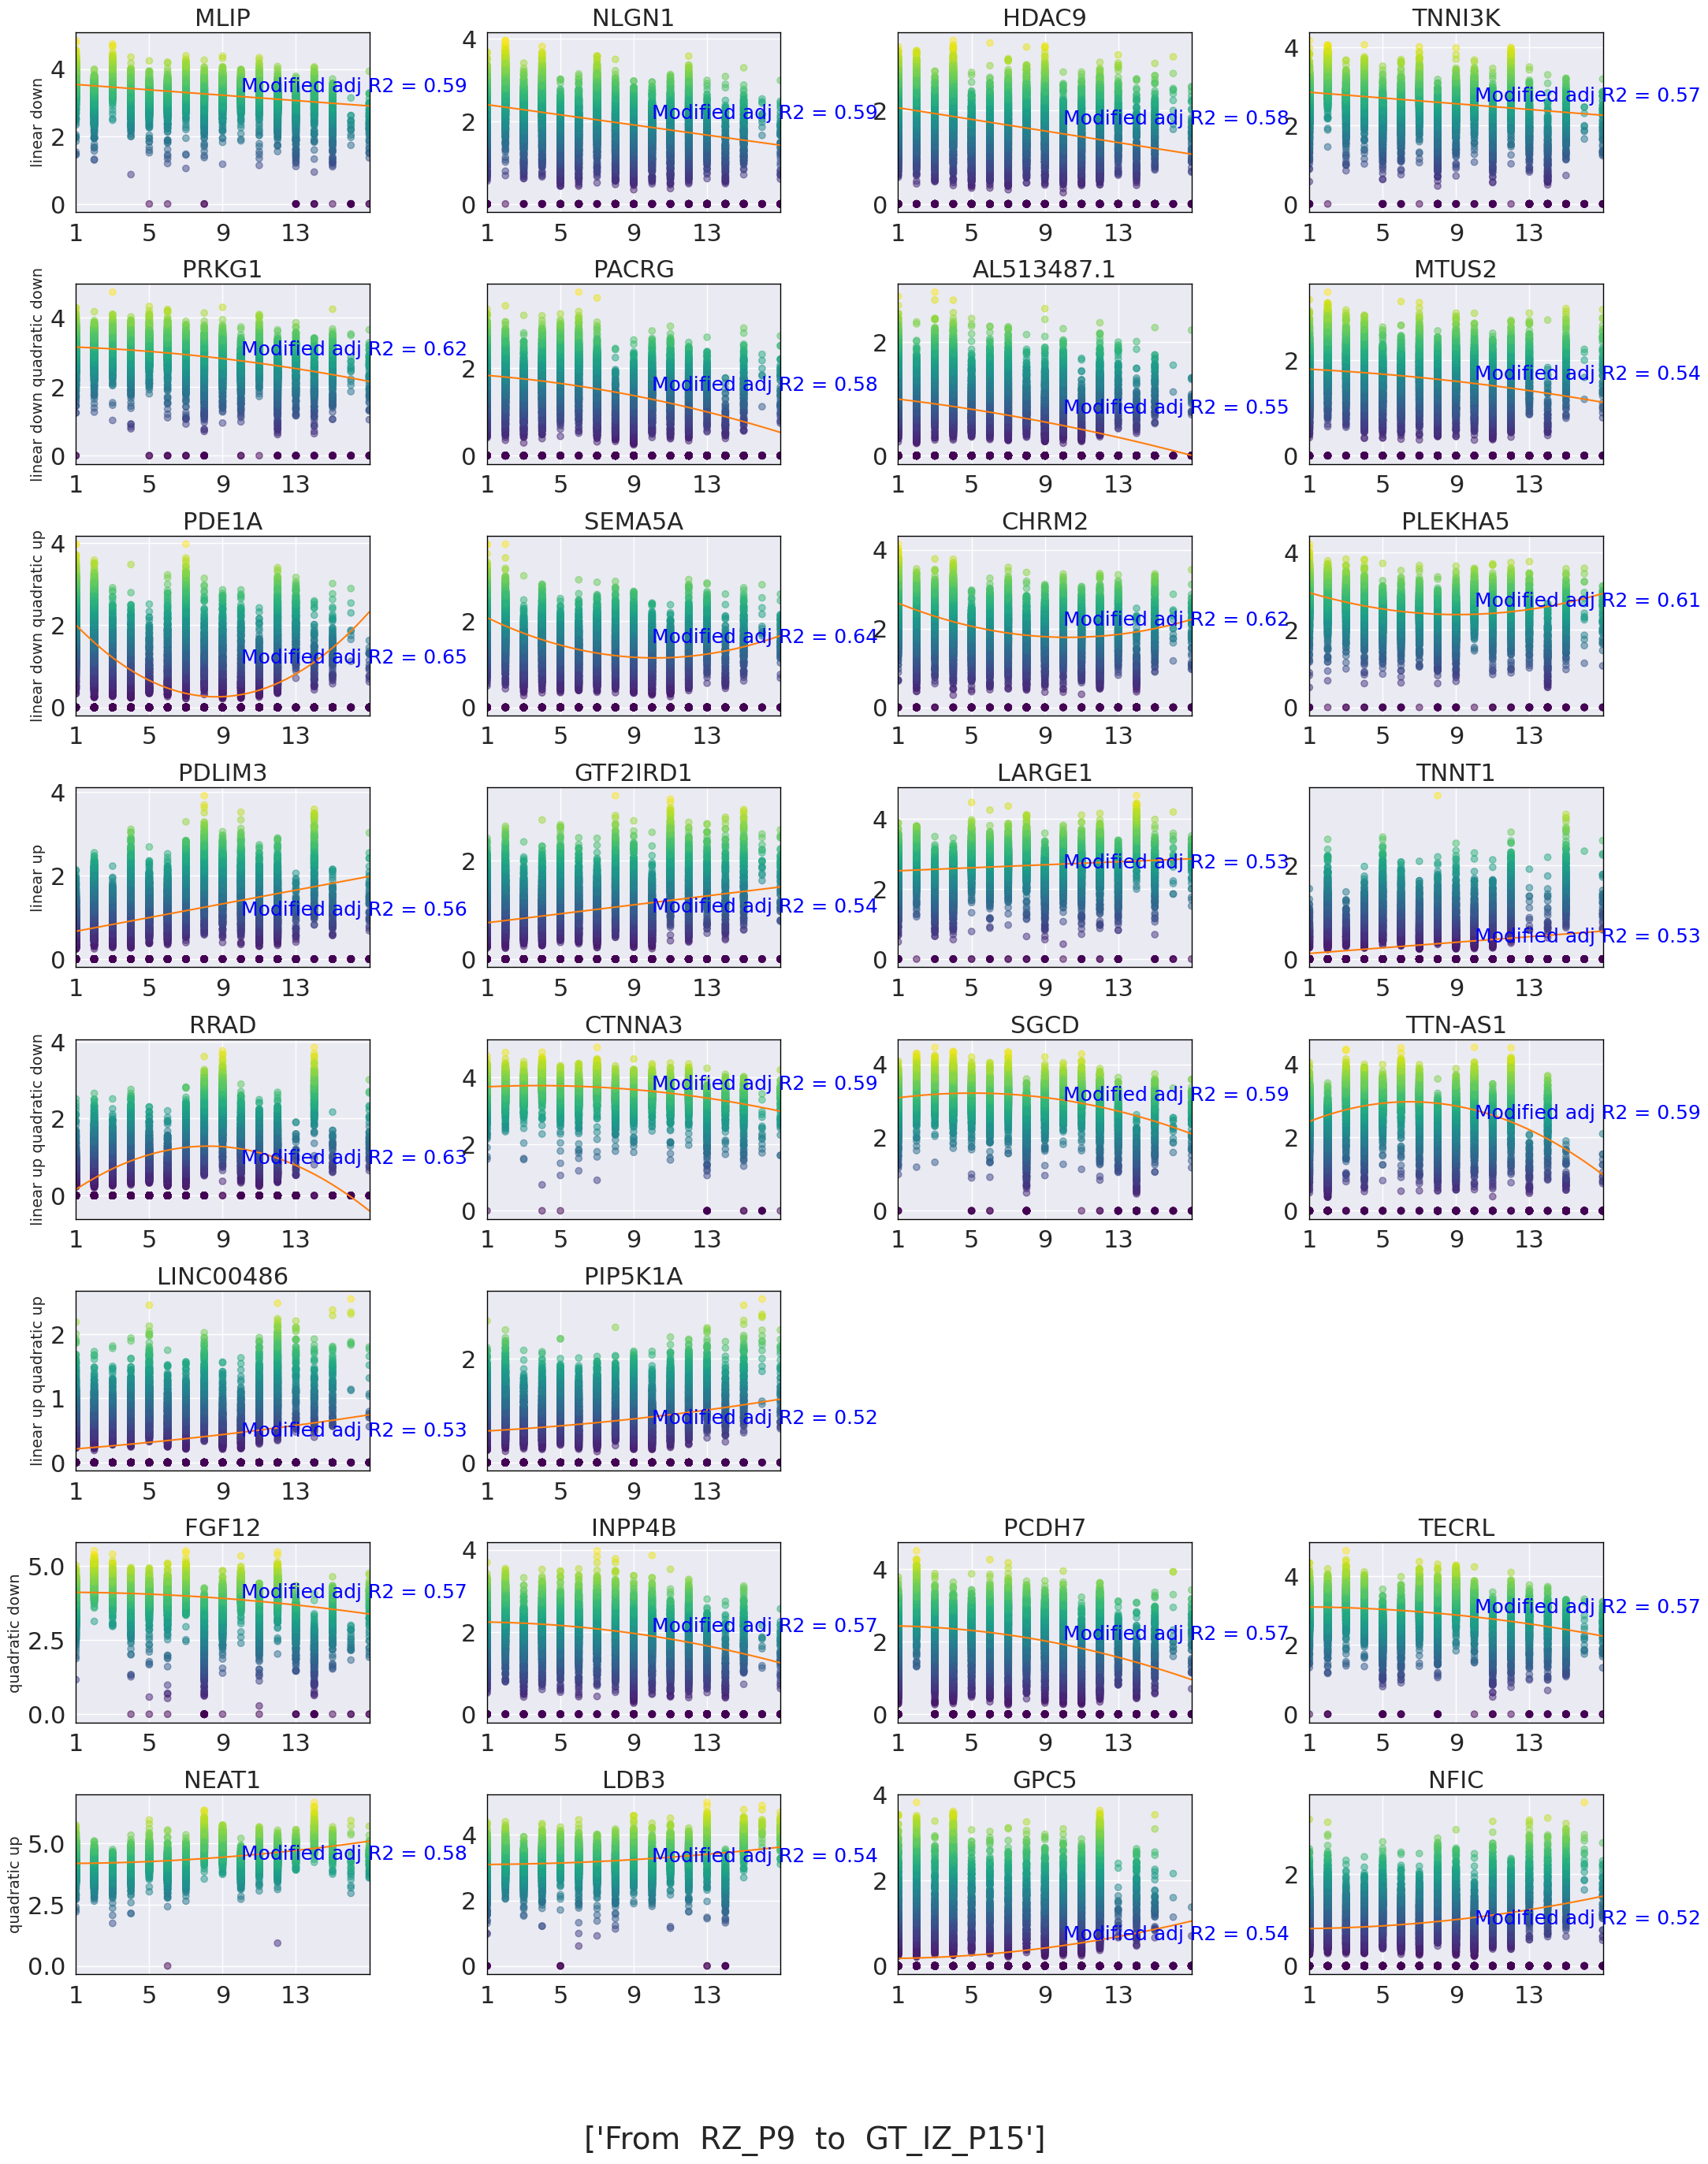

In [12]:
cell_n=cell_names[1] 
data =loadTarget(path_to_results+'/cells/', cell_n)
data=data[data.columns[~data.columns.isin(filtered_names)]] #remove x and y genes
pro=proportions(data)  #Caculate the proportion of Zero for genes
fiternames_pro=list(pro[pro['proportion']> 0.95]['Gene ID']) #Filter genes with high probability zero fraction
data=data[data.columns[~data.columns.isin(fiternames_pro)]]

genes_importance(pro,data,path=path_to_results,name_cell=cell_n,col='Time_score',genes_index=list(range(2, data.shape[1])),p_value=0.01,max_iter_huber=500,epsilon_huber=1.35,genes_interesting=[])


### Myofib cell-type

Name of Cell type : Myofib
sparsity:0.8275345974980163
For this cell_type, p-value of  712 genes are statistically significant.
           Expression pattern  count
5              quadratic down    197
4    linear up quadratic down    192
2    linear down quadratic up    142
0                 linear down    119
6                quadratic up     28
3                   linear up     20
1  linear down quadratic down     14
data saved successfully


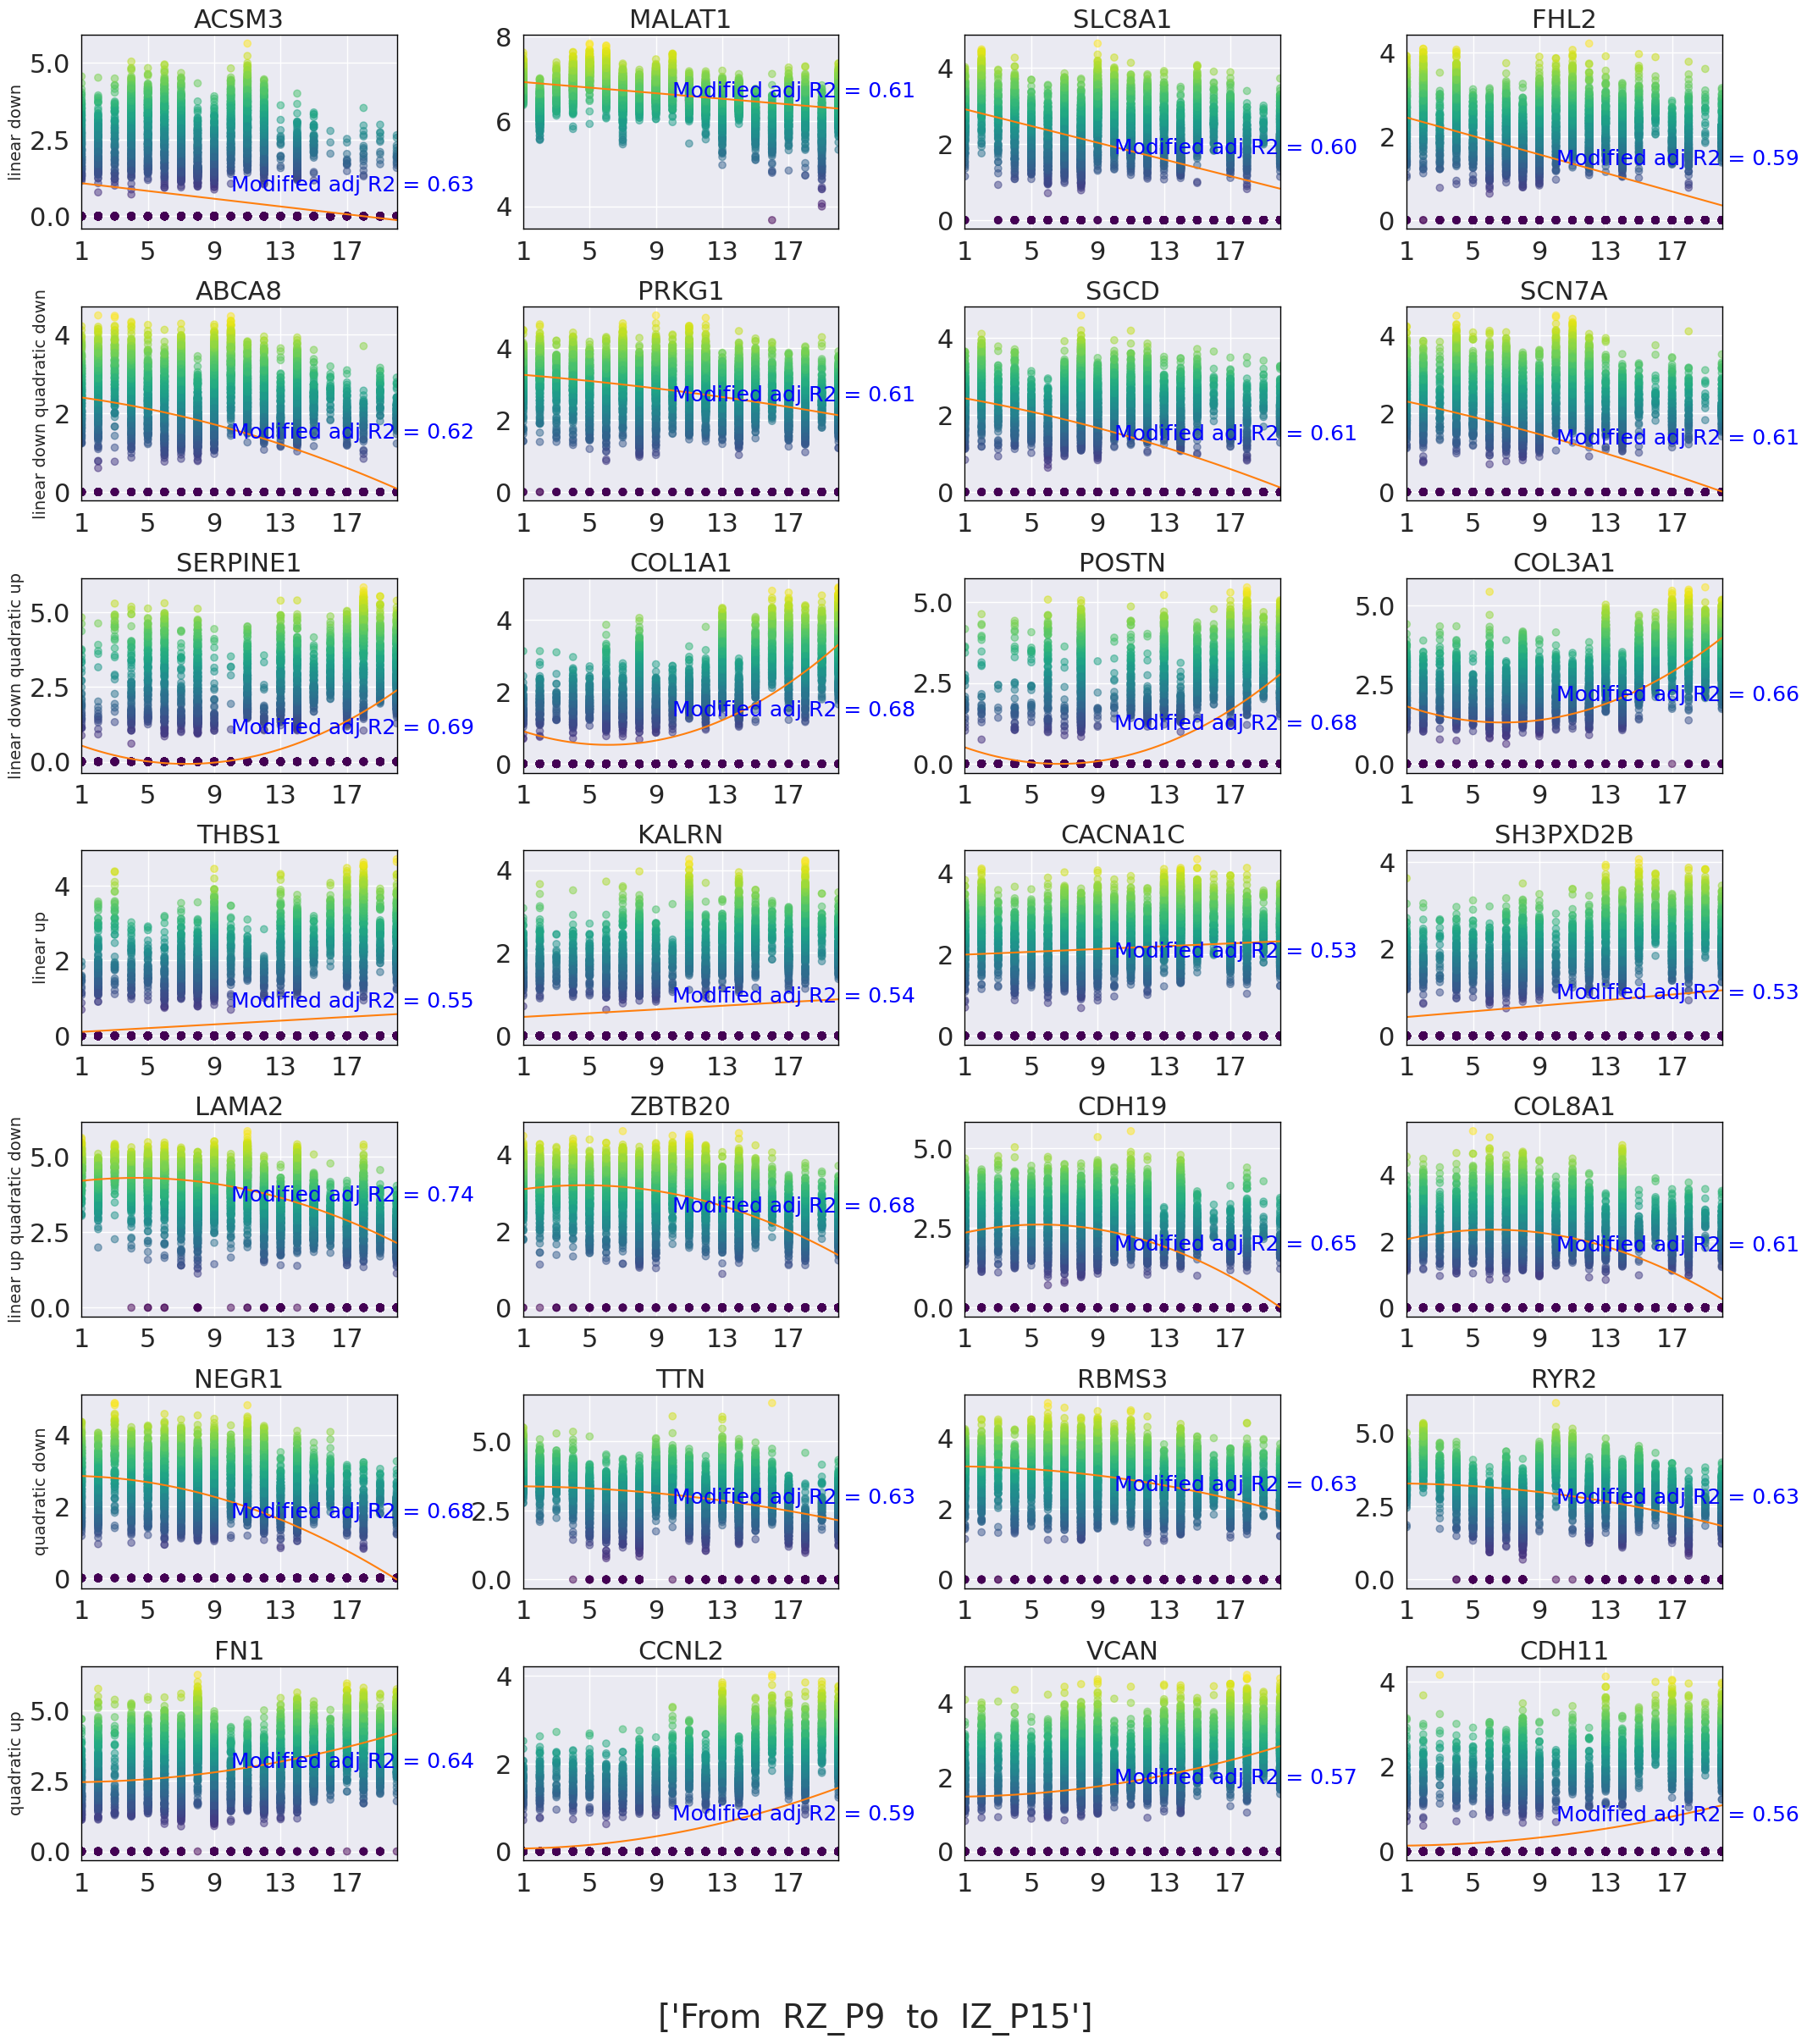

In [13]:
cell_n=cell_names[4]
data =loadTarget(path_to_results+'/cells/', cell_n)

data=data[data.columns[~data.columns.isin(filtered_names)]]
pro=proportions(data)
fiternames_pro=list(pro[pro['proportion']> 0.95]['Gene ID'])
data=data[data.columns[~data.columns.isin(fiternames_pro)]]

genes_importance(pro,data,path=path_to_results,name_cell=cell_n,col='Time_score',genes_index=list(range(2, data.shape[1])),p_value=0.01,max_iter_huber=500,epsilon_huber=1.35,genes_interesting=[])


In [15]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

re 2.2.1
ipykernel._version 6.19.2
json 2.0.9
jupyter_client._version 7.4.8
traitlets._version 5.7.1
traitlets 5.7.1
logging 0.5.1.2
platform 1.0.8
_ctypes 1.1.0
ctypes 1.1.0
zmq.sugar.version 24.0.1
zmq.sugar 24.0.1
zmq 24.0.1
socketserver 0.4
argparse 1.1
zlib 1.0
_curses b'2.2'
dateutil 2.8.2
six 1.16.0
_decimal 1.70
decimal 1.70
jupyter_core.version 5.1.0
jupyter_core 5.1.0
platformdirs.version 2.6.0
platformdirs 2.6.0
entrypoints 0.4
jupyter_client 7.4.8
ipykernel 6.19.2
IPython.core.release 8.7.0
executing.version 1.2.0
executing 1.2.0
pure_eval.version 0.2.2
pure_eval 0.2.2
stack_data.version 0.6.2
stack_data 0.6.2
pygments 2.13.0
ptyprocess 0.7.0
pexpect 4.8.0
pickleshare 0.7.5
backcall 0.2.0
decorator 5.1.1
wcwidth 0.2.5
prompt_toolkit 3.0.36
parso 0.8.3
jedi 0.18.2
urllib.request 3.10
IPython 8.7.0
comm 0.1.2
psutil 5.9.4
debugpy.public_api 1.6.4
debugpy 1.6.4
xmlrpc.client 3.10
http.server 0.6
pkg_resources._vendor.more_itertools 8.12.0
pkg_resources.extern.more_itertools 8.